### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer

plt.style.use("ggplot")

np.random.seed(0)


Bad key "text.kerning_factor" on line 4 in
C:\Users\VISHAL SINGH\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Loading and Exploring the NER Dataset

In [2]:
sentences_words=[]
sentences_tags=[]
file = open('NER-Dataset-10Types-Train.txt', 'r')
lines = file.readlines()
temp_sentence_words=[]
temp_sentence_tags=[]
for line in lines:
    if line=="\n":#Sentences ends at every blank line
        if len(temp_sentence_words)==0:#If zero length sentence is formed, then ignore
            continue
        sentences_words.append(temp_sentence_words)
        temp_sentence_words=[]
        sentences_tags.append(temp_sentence_tags)
        temp_sentence_tags=[]
        continue
    temp=line.split("\t")#splitting to get the tag and the word
    temp[1]=temp[1].split("\n")[0]

    temp_sentence_words.append(temp[0])
    temp_sentence_tags.append(temp[1])
file.close()

In [3]:
sentences_words[3]

['@angelportugues', 'LMAO', '!', 'When', 'is', 'tht', 'one', 'day', '?:', 'P']

In [4]:
sentences_tags[3]

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [5]:
X=sentences_words
Y=sentences_tags

In [6]:
len(X),len(Y)

(900, 900)

### Tokenizing

In [7]:
word_tokenizer = Tokenizer()   #initializing tokenizer
word_tokenizer.fit_on_texts(X) 
X_encoded = word_tokenizer.texts_to_sequences(X) #tokenizing input based on index of every word in vocab set
X_encoded[3]

[1346, 231, 8, 16, 18, 808, 66, 22, 1347, 809]

In [8]:
tags_tokenizer = Tokenizer()
tags_tokenizer.fit_on_texts(Y)
Y_encoded = tags_tokenizer.texts_to_sequences(Y) # tokenizing each tag based on index in tag vocab.
Y_encoded[3]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
NUM_TAGS=len(tags_tokenizer.word_counts)
NUM_TAGS

21

In [10]:
VOCAB_SIZE=len(word_tokenizer.word_counts)
VOCAB_SIZE

4542

In [11]:
#Number of Sentences
len(X)

900

#### Length of the sentences

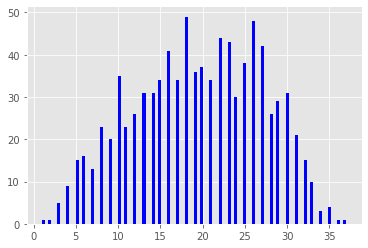

In [12]:
plt.hist([len(s) for s in X], bins=100, color="blue")
plt.show()
MAX_SEQ_LENGTH=max([len(s) for s in X])

In [13]:
MAX_SEQ_LENGTH

37

### Padding Input Sentences and Tags

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
X_padded[0]

Using TensorFlow backend.


array([1333,  804,   35,    8,  108,  197,   30,  805,   45,  198,   49,
       1334,   87,   63,    4,   30,  287, 1335,  584,  379,   95, 1336,
        379, 1337,    8,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [15]:
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
Y_padded[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
#Re-Assigning to X and Y for ease of use
X, Y = X_padded, Y_padded

In [17]:
Y = to_categorical(Y)
print(Y.shape)

(900, 37, 22)


### Build and Compile a Vanilla RNN Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import SimpleRNN, RNN,SpatialDropout1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [19]:
EMBED_DIM=50
NUM_TAGS=Y.shape[2]
VOCAB_SIZE+=1

In [20]:
def evaluate_model(X_train,Y_train,X_test,Y_test):
    VALID_SIZE=0.15 #Validation Split Size
    #Train - Validation Set Split
    X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=1)
    # total number of tags
    
    model = Sequential()

    # Embedding layer 
    model.add(Embedding(input_dim     =  VOCAB_SIZE,         
                            output_dim    =  EMBED_DIM,          
                            input_length  =  MAX_SEQ_LENGTH,              
                            trainable     =  True                     # True - update the embeddings while training
    ))

    
    #Adding RNN Layer 
    model.add(SimpleRNN(64, 
                  return_sequences=True  # True to return whole sequence output 
    ))
    
    model.add(Dropout(0.2)) # Adding dropout to avoid overfitting
    
    # Adding TimeDistributed layer - Softmax output based on number of classes or tags
    model.add(TimeDistributed(Dense(NUM_TAGS, activation='softmax')))

    #Compiling model
    model.compile(loss      =  'categorical_crossentropy',
                      optimizer =  'adam',
                      metrics   =  ['acc', Precision(), Recall()])
    
    # model summary
    model.summary()
    #Hyper-parameters for the model
    epochs=10
    batch_size=128
    

    #Fitting Model
    rnn_training = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, Y_validation))
    #Model Evaluation
    loss, accuracy, precision, recall = model.evaluate(X_train, Y_train, verbose = 1)
    print("Loss: {0},\nTrain Accuracy: {1}".format(loss, accuracy*100))
    print("Precision: {0},\nRecall: {1}".format(precision, recall))
    print(" "*50)
    loss, accuracy, precision, recall = model.evaluate(X_test, Y_test, verbose = 1)
    print("Loss: {0},\nTest Accuracy: {1}".format(loss, accuracy*100))
    print("Precision: {0},\nRecall: {1}".format(precision, recall))
    Y_pred=model.predict(X_test)
    return model,Y_pred,Y_test,accuracy,precision,recall

### 5 - Fold cross Validation

In [21]:
from sklearn.model_selection import ShuffleSplit
#Shuffling and splitting into 5 different sets for cross validation
cv = ShuffleSplit(n_splits=5, test_size=.20, random_state=1)
cv_scores=[0]*5
itr=0
prec=[0]*5
rec=[0]*5
#Initializing
best_pred_set=None
best_test_set=None
best_accuracy=0 
best_precision=0
best_recall=0
#For each split creating and evaluating model
for train_idx,test_idx in cv.split(X):
    itr+=1
    print("*"*100)
    print("                        Cross Validation - {} iteration".format(itr))
    print("*"*100)
    model,Pred_Set,Test_Set,cv_scores[itr-1],prec[itr-1],rec[itr-1]=evaluate_model(X[train_idx],Y[train_idx]
                                                            ,X[test_idx],Y[test_idx])
    if cv_scores[itr-1]>best_accuracy:
        best_accuracy=cv_scores[itr-1]
        best_precision=prec[itr-1]
        best_recall=rec[itr-1]
        best_test_set=Test_Set
        best_pred_set=Pred_Set
        best_model=model

****************************************************************************************************
                        Cross Validation - 1 iteration
****************************************************************************************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 37, 50)            227150    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 37, 64)            7360      
_________________________________________________________________
dropout (Dropout)            (None, 37, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 37, 22)            1430      
Total params: 235,940
Trainable params: 235,940
Non-trainable params: 0
_________________________________________________________

Epoch 1/10
5/5 [==============================] - 2s 143ms/step - loss: 2.9507 - acc: 0.1274 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 2.4932 - val_acc: 0.5000 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 39ms/step - loss: 2.4414 - acc: 0.4435 - precision_2: 0.5000 - recall_2: 6.0642e-04 - val_loss: 2.0277 - val_acc: 0.5198 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 34ms/step - loss: 1.9952 - acc: 0.5150 - precision_2: 0.9216 - recall_2: 0.1369 - val_loss: 1.6019 - val_acc: 0.6299 - val_precision_2: 0.9983 - val_recall_2: 0.4399
Epoch 4/10
5/5 [==============================] - 0s 63ms/step - loss: 1.5953 - acc: 0.6708 - precision_2: 0.9615 - recall_2: 0.3202 - val_loss: 1.2448 - val_acc: 0.8016 - val_precision_2: 0.9911 - val_recall_2: 0.4469
Epoch 5/10
5/5 [==============================] - 0s 34ms/step - loss: 1.2167 - acc: 0.7981 - p

Epoch 3/10
5/5 [==============================] - 0s 58ms/step - loss: 2.0910 - acc: 0.6374 - precision_4: 0.9746 - recall_4: 0.0563 - val_loss: 1.8782 - val_acc: 0.7553 - val_precision_4: 0.9378 - val_recall_4: 0.3318
Epoch 4/10
5/5 [==============================] - 0s 44ms/step - loss: 1.6757 - acc: 0.7939 - precision_4: 0.9634 - recall_4: 0.3094 - val_loss: 1.4916 - val_acc: 0.8096 - val_precision_4: 0.9174 - val_recall_4: 0.3806
Epoch 5/10
5/5 [==============================] - 0s 64ms/step - loss: 1.3255 - acc: 0.8688 - precision_4: 0.9679 - recall_4: 0.3880 - val_loss: 1.1739 - val_acc: 0.8271 - val_precision_4: 0.8910 - val_recall_4: 0.4032
Epoch 6/10
5/5 [==============================] - 0s 49ms/step - loss: 1.0005 - acc: 0.9015 - precision_4: 0.9655 - recall_4: 0.4716 - val_loss: 0.9216 - val_acc: 0.8531 - val_precision_4: 0.8888 - val_recall_4: 0.6119
Epoch 7/10
5/5 [==============================] - 0s 42ms/step - loss: 0.7522 - acc: 0.9218 - precision_4: 0.9581 - recall_4

### Analysis of the best model among the 5 folds

In [22]:
print("Average Test Accuracy is : {}".format(sum(cv_scores)/len(cv_scores)))

Average Test Accuracy is : 0.9041741728782654


In [23]:
print("Best Test Accuracy among all the folds is : {}".format(best_accuracy))

Best Test Accuracy among all the folds is : 0.9644144177436829


In [24]:
print("Average precision : {}, Average Recall : {}".format(sum(prec)/5,sum(rec)/5))

Average precision : 0.9060407400131225, Average Recall : 0.8139940023422241


In [25]:
def f_score(p,r):
    return 2*(p*r)/(p+r)

best_fscore=f_score(best_precision,best_recall)

In [26]:
print("Best Model Precision : {}, Recall : {} and F-Score : {}".format(best_precision,
                                                                       best_recall,best_fscore))

Best Model Precision : 0.9716452360153198, Recall : 0.8849849700927734 and F-Score : 0.9262926212305097


In [27]:
print("Accuracies for the 5 folds are :")
print(*cv_scores)

Accuracies for the 5 folds are :
0.9644144177436829 0.8731231093406677 0.8720721006393433 0.9295795559883118 0.8816816806793213


In [28]:
reverse_word_map = dict(map(reversed, tags_tokenizer.word_index.items()))

### Decoding the predicted tags in the best_pred_set

In [29]:
def decode_pred(Y):
    #Defining an empty matrix of zeros of shape of best_pred_set
    out = np.zeros(Y.shape)
    #Finding the tag index for each sequence which has the highest probablity value 
    idx = Y.argmax(axis=-1)
    #Setting that value to 1 and rest to 0
    out[np.arange(Y.shape[0])[:,None],np.arange(Y.shape[1]),idx] = 1
    pred=np.argmax(out, axis=-1)
    return pred
    

In [30]:
#Finding the index having the max value among the 21 tag values for a certain sequence
best_pred=decode_pred(best_pred_set)
best_test=np.argmax(best_test_set,axis=2)
#Actual Tags(Encoded) for the 2nd sequence in Test Set
best_test[2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

In [31]:
#Predicted Tags(Encoded) for the 2nd sequence in Test Set
best_pred[2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

### Class-wise accuracy for the different tags

In [32]:
true_positive=[0]*(NUM_TAGS)
actual_count=[0]*(NUM_TAGS)
for i in range(best_test.shape[0]):
    for j in range(best_test.shape[1]):
        if best_test[i][j]==0: #Ignore if its 0 as it is present due to padding
            continue
        #if both are equal then increment count by 1 for true positive case
        if best_test[i][j]==best_pred[i][j]:
            true_positive[best_test[i][j]]+=1
        actual_count[best_test[i][j]]+=1

In [33]:
actual_count,true_positive

([0, 3260, 38, 33, 19, 13, 18, 13, 8, 8, 11, 10, 3, 9, 9, 8, 3, 2, 5, 3, 0, 1],
 [0, 3241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
print("*"*100)
print("             Class-Wise Accuracies for different classes are ")
print("*"*100)
class_accuracies=[]
for i in range(1,NUM_TAGS):
    if actual_count[i]!=0:
        class_accuracies.append((true_positive[i]/actual_count[i])*100)
        print("Accuracy of Tag - Class {} is : {} %".format(reverse_word_map.get(i),(class_accuracies[i-1])))
    else:
        class_accuracies.append(0)
        print("Accuracy of Tag - Class {} is 0.0 % ".format(reverse_word_map.get(i)))

****************************************************************************************************
             Class-Wise Accuracies for different classes are 
****************************************************************************************************
Accuracy of Tag - Class o is : 99.41717791411044 %
Accuracy of Tag - Class b-person is : 0.0 %
Accuracy of Tag - Class i-other is : 0.0 %
Accuracy of Tag - Class b-geo-loc is : 0.0 %
Accuracy of Tag - Class i-person is : 0.0 %
Accuracy of Tag - Class b-other is : 0.0 %
Accuracy of Tag - Class b-company is : 0.0 %
Accuracy of Tag - Class b-facility is : 0.0 %
Accuracy of Tag - Class i-facility is : 0.0 %
Accuracy of Tag - Class i-product is : 0.0 %
Accuracy of Tag - Class b-product is : 0.0 %
Accuracy of Tag - Class i-geo-loc is : 0.0 %
Accuracy of Tag - Class b-musicartist is : 0.0 %
Accuracy of Tag - Class i-musicartist is : 0.0 %
Accuracy of Tag - Class i-company is : 0.0 %
Accuracy of Tag - Class i-movie is : 0.0 %
Accuracy

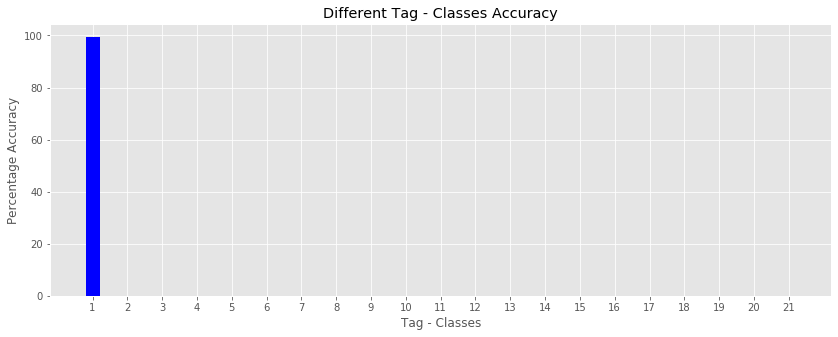

In [35]:
fig = plt.figure(figsize = (14, 5)) 
# creating the bar plot 
category_list=[str(i) for i in range(1,NUM_TAGS)]
plt.bar(category_list, class_accuracies, color ='blue',  
        width = 0.4) 
  
plt.xlabel("Tag - Classes") 
plt.ylabel("Percentage Accuracy") 
plt.title("Different Tag - Classes Accuracy") 
plt.show() 

## Importing Unseen Test Data

In [36]:
test_sentences_words=[]
file = open('NER-Dataset--TestSet.txt', 'r')
lines = file.readlines()
temp_sentence_words=[]
for line in lines:
    if line=="\n":#Blank line represents end of sentence
        test_sentences_words.append(temp_sentence_words)
        temp_sentence_words=[]
        continue
    temp=line.split("\n")[0]
    temp_sentence_words.append(temp)
file.close()

In [37]:
test_sentences_words[0]

['@SammieLynnsMom',
 '@tg1.781',
 'they',
 'will',
 'be',
 'all',
 'done',
 'by',
 'Sunday',
 'trust',
 'me',
 '*wink*']

### Tokenizing words

In [38]:
X_Test=word_tokenizer.texts_to_sequences(test_sentences_words)

In [39]:
X_Test_padded=pad_sequences(X_Test, maxlen=MAX_SEQ_LENGTH, padding="post")

In [40]:
Y_Predicted_Set=best_model.predict(X_Test_padded)

In [41]:
Y_Predicted=decode_pred(Y_Predicted_Set)
Y_Predicted[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [42]:
reverse_word_map = dict(map(reversed, tags_tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

# Creating texts 
Y_Pred_Labels = list(map(sequence_to_text, Y_Predicted))

In [43]:
Y_Pred_Labels[0]

['o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 'o',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]